<a href="https://colab.research.google.com/github/quanquero/PPFM/blob/main/open3d_intro2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install open3d pyntcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.3/346.3 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.3 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
## Libraries

import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Rectangle, FancyArrowPatch
from matplotlib.collections import PatchCollection
from matplotlib import cm

In [ ]:
pcd = o3d.io.read_point_cloud("/content/scaniverse-model 62.ply")
print(f"PointCloud with {len(pcd.points)} points.")

PointCloud with 681270 points.


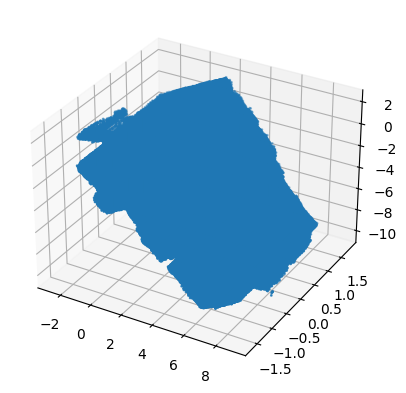

In [ ]:
# Convert the point cloud to a NumPy array
points = np.asarray(pcd.points)

# Downsample the point cloud
voxel_down_pcd = pcd.voxel_down_sample(voxel_size=0.05)

# Remove noise
cl, ind = voxel_down_pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
clean_pcd = voxel_down_pcd.select_by_index(ind)

# Convert cleaned points to a NumPy array
clean_points = np.asarray(clean_pcd.points)

# Visualize the point cloud using Matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(clean_points[:, 0], clean_points[:, 1], clean_points[:, 2], s=1)
plt.show()

In [ ]:
# Reduce std_ratio to filter fewer points
cl, ind = voxel_down_pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=3.0)
clean_pcd = voxel_down_pcd.select_by_index(ind)

# Increase voxel_size to retain more points
voxel_down_pcd = pcd.voxel_down_sample(voxel_size=0.01)

# Save the processed point cloud
o3d.io.write_point_cloud("processed_point_cloud.ply", clean_pcd)
o3d.io.write_point_cloud("processed_point_cloud.pcd", clean_pcd)

# Wall Segmentation
import open3d as o3d

# Use the processed point cloud
clean_pcd = o3d.io.read_point_cloud("processed_point_cloud.ply")

# Set parameters for segmentation
plane_model, inliers = clean_pcd.segment_plane(distance_threshold=0.01,
                                               ransac_n=3,
                                               num_iterations=1000)

# Plane equation: ax + by + cz + d = 0
[a, b, c, d] = plane_model
print(f"Plane equation: {a}x + {b}y + {c}z + {d} = 0")

Plane equation: 0.021234198404638478x + 0.9997721785856113y + 0.002167889363642433z + 1.2163063348336325 = 0


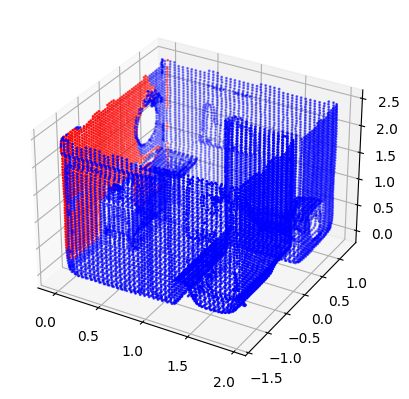

In [ ]:
# Segment the plane and select the points that belong to it
inlier_cloud = clean_pcd.select_by_index(inliers)
outlier_cloud = clean_pcd.select_by_index(inliers, invert=True)

# Visualize the segmentation results
import matplotlib.pyplot as plt
import numpy as np

# Convert point clouds to NumPy arrays
inlier_points = np.asarray(inlier_cloud.points)
outlier_points = np.asarray(outlier_cloud.points)

# Visualize the found plane and remaining points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(inlier_points[:, 0], inlier_points[:, 1], inlier_points[:, 2], color='r', s=1)  # The plane (e.g., walls)
ax.scatter(outlier_points[:, 0], outlier_points[:, 1], outlier_points[:, 2], color='b', s=1)  # Other points
plt.show()

Found wall 1 with plane equation: [ 0.99996182 -0.00511652  0.00708422 -1.95356261]
Found wall 2 with plane equation: [ 0.99999312  0.00282391 -0.00240599  0.00665443]
Found wall 3 with plane equation: [-0.01881724  0.99970488 -0.01536436  1.35558293]
Found wall 4 with plane equation: [-0.00341451  0.99993432  0.01094095 -1.27858281]
Found wall 5 with plane equation: [-0.02646046 -0.01992549  0.99945126 -0.00651215]



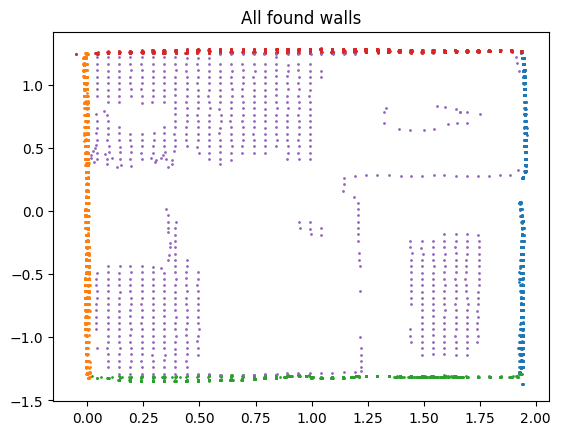

In [ ]:
# Wall Segmentation with RANSAC
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

# Initialize
remaining_pcd = clean_pcd
walls = []

# Set the number of iterations for finding all walls
max_iterations = 5  # Expected number of walls

for i in range(max_iterations):
    try:
        # Apply RANSAC segmentation
        plane_model, inliers = remaining_pcd.segment_plane(distance_threshold=0.01,
                                                           ransac_n=3,
                                                           num_iterations=1000)

        # Select the found plane (wall)
        inlier_cloud = remaining_pcd.select_by_index(inliers)
        outlier_cloud = remaining_pcd.select_by_index(inliers, invert=True)

        # Add the found wall to the list
        walls.append(inlier_cloud)

        # Update the remaining point cloud
        remaining_pcd = outlier_cloud

        print(f"Found wall {i+1} with plane equation: {plane_model}")

    except RuntimeError:
        print(f"No more planes found. Stopping at iteration {i+1}.")
        break

print()
# Visualize all found walls
for wall in walls:
    points = np.asarray(wall.points)
    plt.scatter(points[:, 0], points[:, 1], s=1)
plt.title("All found walls")
plt.show()

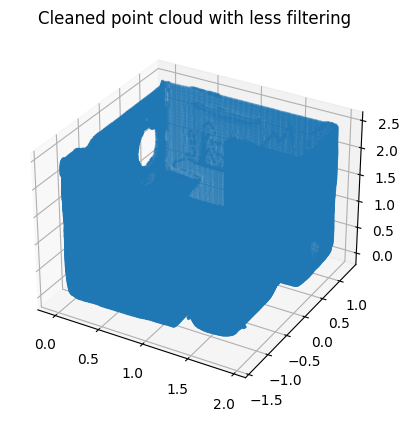

In [ ]:
# Reducing voxel size to preserve details
voxel_down_pcd = pcd.voxel_down_sample(voxel_size=0.02)  # Set voxel size to 0.02

# Noise filtering
cl, ind = voxel_down_pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.5)
clean_pcd = voxel_down_pcd.select_by_index(ind)

# Convert cleaned points to NumPy array
clean_points = np.asarray(clean_pcd.points)

# Visualize result
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(clean_points[:, 0], clean_points[:, 1], clean_points[:, 2], s=1)
plt.title("Cleaned point cloud with less filtering")
plt.show()

Found wall 1 with normal: (0.9999528813668072, -0.005605822658250696, -0.007925263310733776)
Found wall 2 with normal: (0.9999090584305198, -0.012690399311501663, 0.00456383982037737)
Found wall 3 with normal: (0.00502222025220486, -0.02319583037347261, 0.9997183257083084)
Found wall 4 with normal: (-0.0054144913482814345, 0.9999719177882574, 0.005181401192131808)
Found wall 5 with normal: (-0.014055480397713878, 0.9998998062348601, 0.00167957205226827)



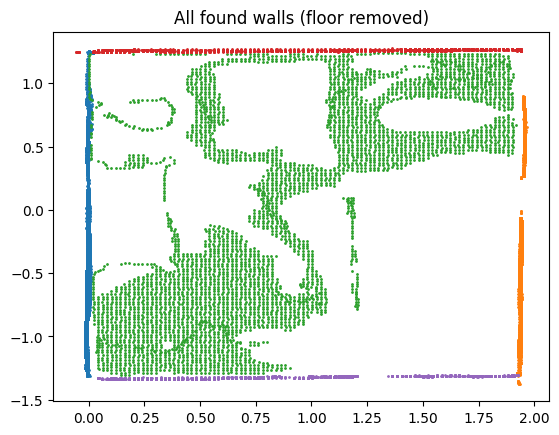

In [ ]:
# Wall Segmentation with improved accuracy
remaining_pcd = clean_pcd
walls = []

max_iterations = 5  # Expected number of walls

for i in range(max_iterations):
    try:
        plane_model, inliers = remaining_pcd.segment_plane(distance_threshold=0.005,  # Lower threshold for better accuracy
                                                           ransac_n=3,
                                                           num_iterations=1500)

        # Extract the wall
        inlier_cloud = remaining_pcd.select_by_index(inliers)
        walls.append(inlier_cloud)

        # Update remaining point cloud
        remaining_pcd = remaining_pcd.select_by_index(inliers, invert=True)

        print(f"Found wall {i+1} with normal: ({plane_model[0]}, {plane_model[1]}, {plane_model[2]})")

    except RuntimeError:
        print(f"No more planes found. Stopping at iteration {i+1}.")
        break

print()
# Visualize walls without the floor
for wall in walls:
    points = np.asarray(wall.points)
    plt.scatter(points[:, 0], points[:, 1], s=1)
plt.title("All found walls (floor removed)")
plt.show()

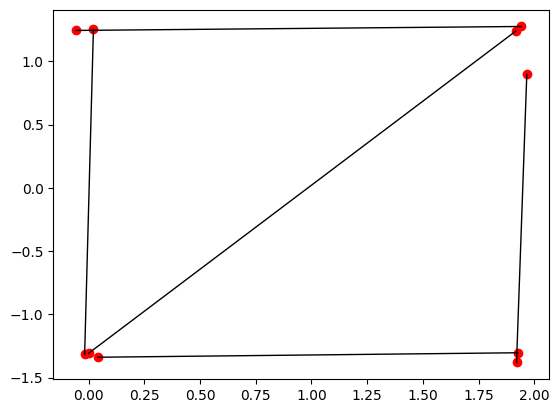

In [ ]:
# Generate a 2D outline from the walls
wall_points = [np.asarray(wall.points) for wall in walls]

corners = []
for points in wall_points:
    x_min, y_min = np.min(points[:, :2], axis=0)
    x_max, y_max = np.max(points[:, :2], axis=0)

    corners.append([x_min, y_min])
    corners.append([x_max, y_max])

# Create lines between corner points
for i in range(0, len(corners) - 1, 2):
    x1, y1 = corners[i]
    x2, y2 = corners[i+1]
    plt.plot([x1, x2], [y1, y2], 'k-', linewidth=1)

# Visualize the result
plt.scatter(*zip(*corners), color='red')
plt.show()

Found wall 1 with normal: [ 9.99991767e-01  3.05735533e-04 -4.04619486e-03]
Found wall 2 with normal: [ 0.99996959 -0.00476497  0.00617432]
Found wall 3 with normal: [2.61954503e-03 9.99996539e-01 2.46288374e-04]
Found wall 4 with normal: [-0.00370646 -0.01983765  0.99979634]
Found wall 5 with normal: [-0.0190309   0.99978127  0.00867407]


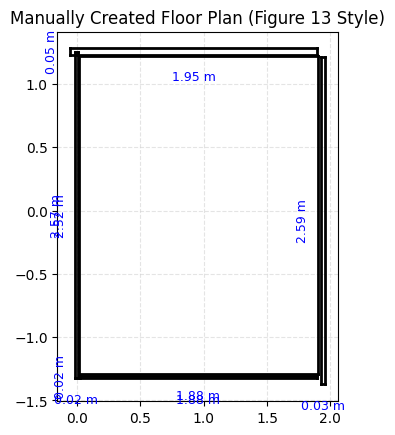

In [ ]:
# Downsample and denoise point cloud
voxel_down_pcd = pcd.voxel_down_sample(voxel_size=0.05)
cl, ind = voxel_down_pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
clean_pcd = voxel_down_pcd.select_by_index(ind)

# Wall Segmentation for Enhanced Figure
remaining_pcd = clean_pcd
walls = []

max_iterations = 5  # Number of walls expected

for i in range(max_iterations):
    try:
        plane_model, inliers = remaining_pcd.segment_plane(distance_threshold=0.005, ransac_n=3, num_iterations=1500)
        inlier_cloud = remaining_pcd.select_by_index(inliers)
        walls.append(inlier_cloud)
        remaining_pcd = remaining_pcd.select_by_index(inliers, invert=True)
        print(f"Found wall {i+1} with normal: {plane_model[:3]}")
    except RuntimeError:
        print(f"No more planes found. Stopping at iteration {i+1}.")
        break

## Manually Created Style (Figure 13)
fig13, ax13 = plt.subplots()

# Basic wall representation (simple, clean)
for wall in walls:
    points = np.asarray(wall.points)
    x_min, y_min = np.min(points[:, :2], axis=0)
    x_max, y_max = np.max(points[:, :2], axis=0)

    # Draw clean, simple wall outlines
    ax13.plot([x_min, x_max], [y_min, y_min], 'k-', linewidth=2)
    ax13.plot([x_min, x_min], [y_min, y_max], 'k-', linewidth=2)
    ax13.plot([x_max, x_max], [y_min, y_max], 'k-', linewidth=2)
    ax13.plot([x_min, x_max], [y_max, y_max], 'k-', linewidth=2)

# Add grid lines for clarity
ax13.grid(True, which='both', linestyle='--', color='lightgrey', alpha=0.6)

# Room dimension labels
for wall in walls:
    points = np.asarray(wall.points)
    x_min, y_min = np.min(points[:, :2], axis=0)
    x_max, y_max = np.max(points[:, :2], axis=0)

    ax13.text((x_min + x_max) / 2, y_min - 0.2, f'{abs(x_max - x_min):.2f} m', fontsize=9, ha='center', color='blue')
    ax13.text(x_min - 0.2, (y_min + y_max) / 2, f'{abs(y_max - y_min):.2f} m', fontsize=9, va='center', color='blue', rotation=90)

# Set title and aspect ratio
ax13.set_aspect('equal')
ax13.set_title("Manually Created Floor Plan (Figure 13 Style)")
plt.show()

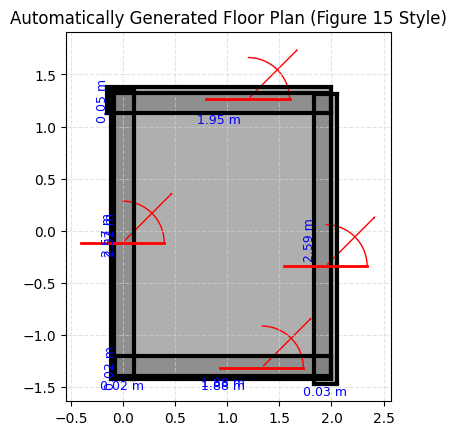

In [ ]:
# Automatically Generated Style (Figure 15)
fig15, ax15 = plt.subplots()

# Enhanced wall representation with double walls and shading
wall_thickness = 0.1  # Wall thickness
patches = []

for wall in walls:
    points = np.asarray(wall.points)
    x_min, y_min = np.min(points[:, :2], axis=0)
    x_max, y_max = np.max(points[:, :2], axis=0)

    # Draw double walls with shading
    ax15.plot([x_min - wall_thickness, x_max + wall_thickness], [y_min - wall_thickness, y_min - wall_thickness], 'k-', linewidth=3)
    ax15.plot([x_min - wall_thickness, x_min - wall_thickness], [y_min - wall_thickness, y_max + wall_thickness], 'k-', linewidth=3)
    ax15.plot([x_max + wall_thickness, x_max + wall_thickness], [y_min - wall_thickness, y_max + wall_thickness], 'k-', linewidth=3)
    ax15.plot([x_min - wall_thickness, x_max + wall_thickness], [y_max + wall_thickness, y_max + wall_thickness], 'k-', linewidth=3)

    # Filled rectangle between double walls
    rect = Rectangle((x_min - wall_thickness, y_min - wall_thickness),
                     (x_max + wall_thickness) - (x_min - wall_thickness),
                     (y_max + wall_thickness) - (y_min - wall_thickness),
                     edgecolor=None, facecolor=cm.Greys(0.6), alpha=0.6)
    patches.append(rect)

# Add filled areas between walls
collection = PatchCollection(patches, match_original=True)
ax15.add_collection(collection)

# Door detection and representation
door_height_threshold = 2.0  # Typical door height
door_color = 'red'

for wall in walls:
    points = np.asarray(wall.points)

    # Detect doors by height threshold
    door_candidates = points[(points[:, 2] < door_height_threshold) & (points[:, 2] > 0.5)]

    if len(door_candidates) > 0:
        door_center = np.mean(door_candidates[:, :2], axis=0)

        # Draw the door frame and arc for swing
        door_width = 0.8
        ax15.plot([door_center[0] - door_width / 2, door_center[0] + door_width / 2], [door_center[1], door_center[1]], door_color, linewidth=2)
        arc = Arc([door_center[0], door_center[1]], door_width, door_width, angle=0, theta1=0, theta2=90, color=door_color)
        ax15.add_patch(arc)

        # Add arrow for door swing
        ax15.add_patch(FancyArrowPatch((door_center[0], door_center[1]),
                                        (door_center[0] + 0.5, door_center[1] + 0.5),
                                        arrowstyle='->', color=door_color))

# Grid lines and dimension labels
ax15.grid(True, which='both', linestyle='--', color='lightgrey', alpha=0.6)

# Room and wall dimension labels
for wall in walls:
    points = np.asarray(wall.points)
    x_min, y_min = np.min(points[:, :2], axis=0)
    x_max, y_max = np.max(points[:, :2], axis=0)

    ax15.text((x_min + x_max) / 2, y_min - wall_thickness * 2, f'{abs(x_max - x_min):.2f} m', fontsize=9, ha='center', color='blue')
    ax15.text(x_min - wall_thickness * 2, (y_min + y_max) / 2, f'{abs(y_max - y_min):.2f} m', fontsize=9, va='center', color='blue', rotation=90)

# Set title and aspect ratio
ax15.set_aspect('equal')
ax15.set_title("Automatically Generated Floor Plan (Figure 15 Style)")
plt.show()

Found wall 1 with normal: [ 0.9999586   0.00140896 -0.00898938]
Found wall 2 with normal: [ 0.9999872  -0.00417569  0.00285591]
Found wall 3 with normal: [0.00336357 0.99999159 0.00234864]
Found wall 4 with normal: [-0.02153338 -0.0196763   0.99957449]
Found wall 5 with normal: [-0.00873668  0.99996101  0.00128155]
Found wall 6 with normal: [ 0.99991207 -0.01030566 -0.00834592]
Found wall 7 with normal: [9.05784621e-04 9.99960256e-01 8.86937967e-03]


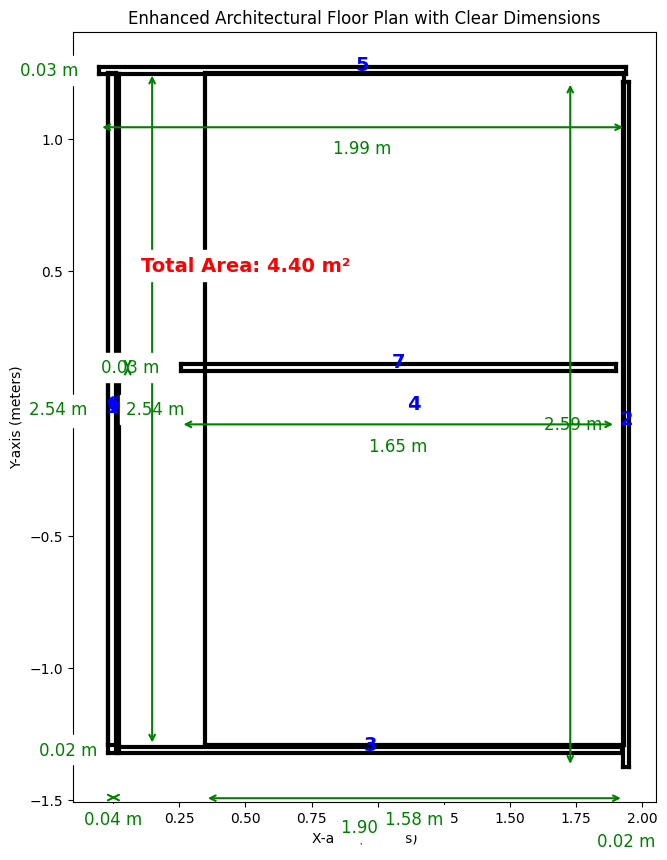

In [ ]:
# Downsample and denoise the point cloud
voxel_down_pcd = pcd.voxel_down_sample(voxel_size=0.05)
cl, ind = voxel_down_pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
clean_pcd = voxel_down_pcd.select_by_index(ind)

# Wall Segmentation
remaining_pcd = clean_pcd
walls = []

max_iterations = 7 # Increase for more walls detection

for i in range(max_iterations):
    try:
        plane_model, inliers = remaining_pcd.segment_plane(distance_threshold=0.005, ransac_n=3, num_iterations=1500)
        inlier_cloud = remaining_pcd.select_by_index(inliers)
        walls.append(inlier_cloud)
        remaining_pcd = remaining_pcd.select_by_index(inliers, invert=True)
        print(f"Found wall {i+1} with normal: {plane_model[:3]}")
    except RuntimeError:
        print(f"No more planes found. Stopping at iteration {i+1}.")
        break

### Drawing the Enhanced Architectural Floor Plan ###

fig, ax = plt.subplots(figsize=(12, 10))  # Adjust figure size to fit complex plans

# Initialize variable to calculate total area
area = 0
wall_number = 1  # To track the numbers in the floor plan

# Draw wall outlines and calculate area
for wall in walls:
    points = np.asarray(wall.points)
    x_min, y_min = np.min(points[:, :2], axis=0)
    x_max, y_max = np.max(points[:, :2], axis=0)

    # Draw the walls (rectangles based on min and max coordinates)
    ax.plot([x_min, x_max], [y_min, y_min], 'k-', linewidth=3)  # Bottom wall
    ax.plot([x_min, x_min], [y_min, y_max], 'k-', linewidth=3)  # Left wall
    ax.plot([x_max, x_max], [y_min, y_max], 'k-', linewidth=3)  # Right wall
    ax.plot([x_min, x_max], [y_max, y_max], 'k-', linewidth=3)  # Top wall

    # Calculate area (assuming rectangular space)
    wall_length = x_max - x_min
    wall_height = y_max - y_min
    area += wall_length * wall_height

    # Annotate wall number inside the room section
    ax.text((x_min + x_max) / 2, (y_min + y_max) / 2, f'{wall_number}', fontsize=14, ha='center', color='blue', weight='bold')
    wall_number += 1

    # Annotate horizontal dimension (shifted above or below wall)
    ax.text((x_min + x_max) / 2, y_min - 0.3, f'{wall_length:.2f} m', fontsize=12, ha='center', color='green', backgroundcolor='white')
    ax.annotate("", xy=(x_max, y_min - 0.2), xytext=(x_min, y_min - 0.2),
                arrowprops=dict(arrowstyle='<->', color='green', lw=1.5))

    # Annotate vertical dimension (shifted left or right of the wall)
    ax.text(x_min - 0.3, (y_min + y_max) / 2, f'{wall_height:.2f} m', fontsize=12, va='center', color='green', backgroundcolor='white')
    ax.annotate("", xy=(x_min - 0.2, y_max), xytext=(x_min - 0.2, y_min),
                arrowprops=dict(arrowstyle='<->', color='green', lw=1.5))

# Display total area centrally or in a fixed position at the bottom
ax.text(0.5, 0.5, f'Total Area: {area:.2f} m²', fontsize=14, ha='center', color='red', weight='bold', backgroundcolor='white')

# Set title and aspect ratio
ax.set_aspect('equal')
ax.set_title("Enhanced Architectural Floor Plan with Clear Dimensions")
ax.set_xlabel("X-axis (meters)")
ax.set_ylabel("Y-axis (meters)")
ax.grid(False)  # Add grid for better clarity
ax.axis('on')  # Show axis for scaling reference

plt.show()